In [1]:
from queue import PriorityQueue
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import copy
import time
import random

In [2]:
#-----------------------------------------------------PUZZLE MAKING FUNCTIONS-----------------------------------------------------


#Generate solved puzzle of given size
def solved(size):
    #Make puzzle
    puzzle = []
    for r in range(size):
        #make rows
        row = []
        for c in range(size):
            #insert tile into row
            row.append((r*size)+c+1)
        #insert row into puzzle
        puzzle.append(row)
    #make sure to include empty position
    puzzle[size-1][size-1] = 0
    return puzzle


#allow user to enter puzzle state of given size
def user(size):
    #make puzzle
    puzzle = []
    for r in range(size):
        #make row
        row = []
        for c in range(size):
            #get user input and insert tile into row
            row.append(int(input(f"Tile at row {r} and column {c}:")))
        #insert row into puzzle
        puzzle.append(row)
    return puzzle


#allow for random puzzles to be created
def rand(size, depth):
    #start with solved state to guarantee all tiles are present
    r = solved(size)
    #randomize the number of moves to take
    numMoves = random.randint(0,depth)
    for move in range(numMoves):
        #get the children of the puzzle
        c = children(r)
        #pick a random child of the puzzle and replace the puzzle with it
        r = c[random.randint(0,len(c)-1)]
    return r


#execute move on puzzle
def move(puzzle, direction):
    zero = find(puzzle,0)
    #replace the empty tile with the tile in the given direction
    puzzle[zero[0]][zero[1]] = puzzle[zero[0]+direction[0]][zero[1]+direction[1]]
    #put an empty tile where the other tile used to be
    puzzle[zero[0]+direction[0]][zero[1]+direction[1]] = 0


#get all valid children of a puzzle
def children(puzzle):
    children = []
    #find the empty position of the puzzle
    zero = find(puzzle, 0)
    #iterate over all moves
    for move in [(1,0),(0,1),(-1,0),(0,-1)]:
        #check if the move goes out of the range of the puzzle
        if 0<=zero[0]+move[0]<len(puzzle) and 0<=zero[1]+move[1]<len(puzzle):
            #make sure to make a deep copy of the puzzle list
            child = copy.deepcopy(puzzle)
            #swap zero and neighbour
            child[zero[0]][zero[1]] = child[zero[0]+move[0]][zero[1]+move[1]]
            child[zero[0]+move[0]][zero[1]+move[1]] = 0
            #add child to list of children
            children.append(child)
    return children

In [3]:
#--------------------------------------------------------UTILITY FUNCTIONS--------------------------------------------------------


#calculate manhattan distance between two pairs
def manhattanDistance(a,b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


#find given tile in puzzle and return pair (r,c)
def find(puzzle, tile):
    #iterate over rows
    for r in range(len(puzzle)):
        #iterate over columns
        for c in range(len(puzzle[r])):
            t = puzzle[r][c]
            #check for found tile
            if(t == tile):
                return (r,c)
    return (-1,-1)


#pad a given tile to a string of constant width based on puzzle size
def pad(size, tile):
    #calculate the largest tile and its length when converted to a string
    maxTile = size**2-1
    maxString = str(maxTile)
    maxLen = len(maxString)
    #convert the tile to a string
    tileString = str(tile)
    tileLen = len(tileString)
    #pad the tile string with spaces to make it the same length as the longest possible tile
    paddedString = " "*(maxLen-tileLen)+tileString
    return paddedString


#print a given puzzle in a nice way
def printPuzzle(puzzle):
    width = 0;
    #iterate over all rows
    for r in range(len(puzzle)):
        offsetString = " "*len(puzzle)
        rowString = "|".join(pad(len(puzzle),t) for t in puzzle[r])
        #print row string offset to the rightteal
        print(offsetString+rowString)
        lineString = " "*len(offsetString)+"-"*len(rowString)
        #only print row delimeter if not the last row
        if r != puzzle[len(puzzle)-1]:
            print(lineString)
        width = 2*len(offsetString)+len(rowString)
    #end printing the puzzle with a line
    print("-"*width)


#print the path taken to a given path
def printPath(path):
    #print the puzzles in the order they occur in the path
    for puzzle in path:
        printPuzzle(puzzle)

In [4]:
#--------------------------------------------------------HEURISTIC FUNCTIONS------------------------------------------------------


#simply return 0
def uniformCostHeuristic(current, goal):
    return 0


#return the number of misplaced tiles between the two puzzles
def misplacedTileHeuristic(current, goal):
    #to start, no tiles are misplaced
    count = 0
    #iterate over all tiles
    for t in range(len(current)**2-1):
        #find tile in current puzzle
        c = find(current, t)
        #find tile in goal puzzle
        g = find(goal, t)
        #use boolean value coercement to 1 to add if mismatched
        count += c!=g
    return count


#return manhattan distance between two puzzles
def manhattanDistanceHeuristic(current, goal):
    #to start, distance is 0
    distance = 0
    for t in range(len(current)**2-1):
        #find tile in current puzzle
        c = find(current, t)
        #find tile in goal puzzle
        g = find(goal, t)
        #accumulate distance
        distance += manhattanDistance(c,g)
    return distance

In [5]:
#-------------------------------------------------------SEARCH FUNCTIONS-------------------------------------------------------


#general search function
def generalSearch(initial, goal, heuristic):
    #start timer
    start = round(time.time()*1000)
    #construct priority queue
    nodes = PriorityQueue()
    #construct list to keep track of visited states
    visited = []
    #insert inital state into queue with depth 0, priority 0, and path of itself
    nodes.put((0,[0,initial,[initial]]))
    while True:
        #return failure if no nodes left
        if nodes.empty():
            return "FAILURE"
        #get and remove top node
        node = nodes.get()
        depth = node[1][0]
        puzzle = node[1][1]
        path = node[1][2]
        visited.append(puzzle)
        #add node to visited
        #return node if puzzle is goal state
        if puzzle == goal:
            end = round(time.time()*1000)
            return (depth,path,len(visited),nodes.qsize(),end-start)
        #expand to all children
        for child in children(puzzle):
            #if the child is not visited, insert it into the queue to be visited
            if child not in visited:
                priority = depth+1+heuristic(child,goal)
                newdepth = depth+1
                newpath = copy.deepcopy(path)
                newpath.append(child)
                nodes.put((priority,[newdepth,child,newpath]))

In [6]:
#-------------------------------------------------TESTING AND DRIVER FUNCTIONS-------------------------------------------------


#all test cases from the project pdf with their index according to their depth
test = [
    [[1,2,3],[4,5,6],[7,8,0]],
    None,
    [[1,2,3],[4,5,6],[0,7,8]],
    None,
    [[1,2,3],[5,0,6],[4,7,8]],
    None,
    None,
    None,
    [[1,3,6],[5,0,2],[4,7,8]],
    None,
    None,
    None,
    [[1,3,6],[5,0,7],[4,8,2]],
    None,
    None,
    None,
    [[1,6,7],[5,0,3],[4,8,2]],
    None,
    None,
    None,
    [[7,1,2],[4,8,5],[6,3,0]],
    None,
    None,
    None,
    [[0,7,2],[4,6,1],[3,5,8]]
]


#run all test cases for a given heuristic
def testCases(heuristic):
    goal = solved(3)
    result = []
    #search for all puzzles in the test list
    for puzzle in test:
        if puzzle == None:
            result.append(None)
        else:
            result.append(generalSearch(puzzle,goal,heuristic)[0])
    for depth in range(len(result)):
        #if the depth is not what is expected, the search has failed
        if result[depth] != None:
            if depth == result[depth]:
                print(f"PASSED DEPTH {depth}")
            else:
                print(f"FAILED DEPTH {depth} - RESULT DEPTH AT {result[depth]}")

                

#function to run all tests on all heuristics
def testAll():
    if input("Are you sure you want to run these tests?") == "yes":
        print("TESTING MANHATTAN DISTANCE HEURISTIC")
        testCases(manhattanDistanceHeuristic)
        print("-"*25)
        print("TESTING MISPLACED TILE HEURISTIC")
        testCases(misplacedTileHeuristic)
        print("-"*25)
        print("TESTING UNIFORM COST HEURISTIC")
        testCases(uniformCostHeuristic)
        
        

#driver to run search algorithm generally
def driver():
    #get user input to decide what size
    print("What size puzzle would you like to solve?")
    size = int(input())
    if size < 1:
        print("INVALID SIZE SELECTION")
        return
    #get user puzzle or random puzzle
    print("Would you like to input a puzzle to solve or use a  random one?")
    print("\t1: user defined puzzle")
    print("\t2: random puzzle")
    option = int(input())
    if option == 1:
        initial = user(size)
    elif option == 2:
        initial = rand(size,100*size**2)
    else:
        print("INVALID PUZZLE CHOICE")
        return
    #allow user to select heuristic
    print("What heuristic would you like to use? Options are:")
    print("\t1: manhattanDistanceHeuristic")
    print("\t2: misplacedTileHeuristic")
    print("\t3: uniformCostHeuristic")
    option = int(input())
    if option == 1:
        heuristic = manhattanDistanceHeuristic
    elif option == 2:
        heuristic = misplacedTileHeuristic
    elif option == 3:
        heuristic = uniformCostHeuristicteal
    else:
        print("INVALID HEURISTIC INPUT")
        return
    #run search function and print solution (if there is one)
    solution = generalSearch(initial,solved(size),heuristic)
    if solution == "FAILURE":
        print("No solution found")
    else:
        print(f"Solution found at depth {solution[0]}")
        print(f"Visited {solution[2]} nodes")
        print(f"{solution[3]} nodes in the frontier")
        print(f"Search took {solution[4]} milliseconds")
        printPath(solution[1])


#monte carlo simulation to approximate visited states and frontier size per depth per heuristic
#note that this is much too slow, so I used C++ to run the monte carlo search
def monteCarlo(size, simulations, heuristic):
    #make goal state
    goal = solved(size)
    #keep track of solution depths, visited nodes, frontier sizes, and search times
    depthDict = {}
    visitedDict = {}
    frontierDict = {}
    timeDict = {}
    #for loop to run many simulations
    for simulation in range(simulations):
        #make random node
        initial = rand(size,100*size**2)
        #run search
        solution = generalSearch(initial,goal,heuristic)
        depth = solution[0]
        visited = solution[2]
        frontier = solution[3]
        time = solution[4]
        #add data to lists
        if depth not in depthDict:
            depthDict[depth] = 1
            visitedDict[depth] = visited
            frontierDict[depth] = frontier
            timeDict[depth] = time
        else:
            depthDict[depth] += 1
            visitedDict[depth] += visited
            frontierDict[depth] += frontier
            timeDict[depth] += time
    for depth in range(len(depthDict)-1):
        if depth in depthDict:
            visitedDict[depth] /= depthDict[depth]
            frontierDict[depth] /= depthDict[depth]
            timeDict[depth] /= depthDict[depth]
    return (visitedDict, frontierDict, timeDict)


#plot all monte carlo simulation results for given heuristic
def plotMC(visited, frontier, time):
    visitedList = sorted(visited.items())
    vx, vy = zip(*visitedList)
    visitedPlot = plt.plot(vx,vy, label = "Visited Nodes", color = "teal")
    frontierList = sorted(frontier.items())
    fx, fy = zip(*frontierList)
    frontierPlot = plt.plot(fx,fy, label = "Frontier Size", color = "firebrick")
    timeList = sorted(time.items())
    tx, ty = zip(*timeList)
    timePlot = plt.plot(tx,ty, label = "Search Time", color = "midnightblue")
    plt.gca().legend(loc = "upper left")
    plt.show()

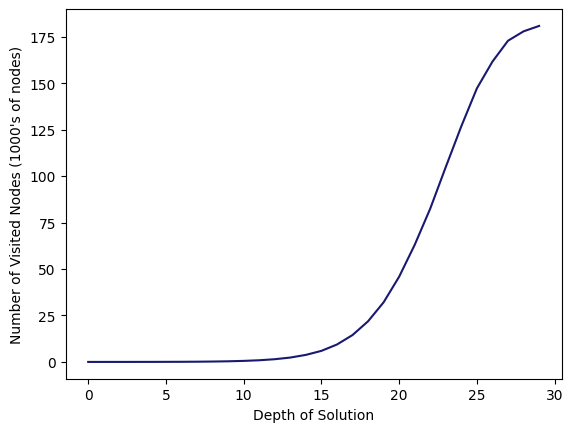

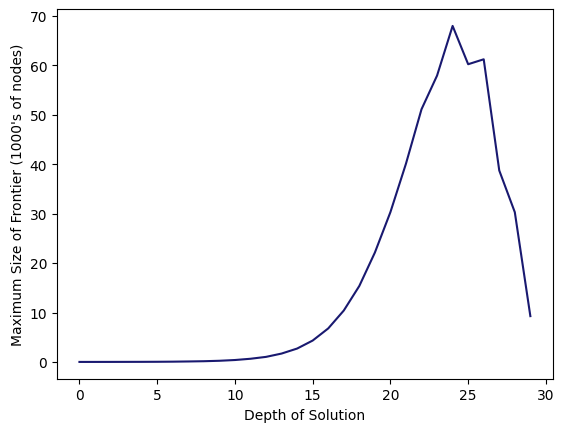

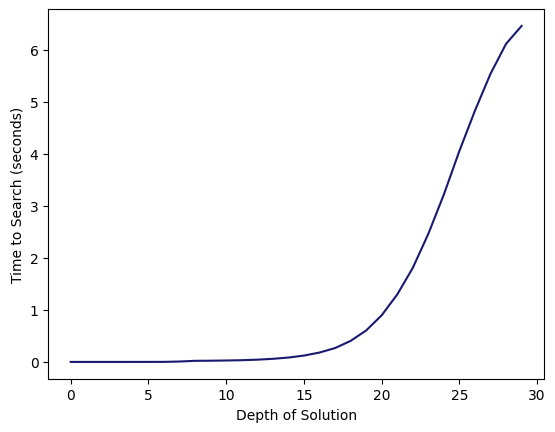

In [17]:
#results of monte carlo simulation with 100000 uniform cost searches in c++
depthUC = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
visitedUC = [1, 1.5, 4.61742, 10.3473, 22.7988, 40.5089, 69.7405, 119.503, 208.944, 339.157, 557.55, 893.925, 1460.89, 2352.31, 3786.56, 5954.83, 9374.97, 14463.1, 21877.1, 32088.9, 45881.8, 63027.1, 82546.4, 104944, 126866, 147222, 161608, 172839, 177882, 180803]
frontierUC = [0, 1.5, 4.01601, 10.3473, 16.1263, 28.5089, 51.7073, 93.0422, 143.051, 231.979, 385.468, 640.009, 1021.14, 1693.02, 2706.36, 4326.04, 6780.54, 10399.1, 15377.5, 22132.8, 30321.9, 40130.3, 51141.3, 57959.6, 68007.6, 60254.2, 61253.5, 38744.8, 30304, 9268.5]
timeUC = [0.00401606, 0.0211073, 0.0635614, 0.135964, 0.290214, 0.507157, 0.907028, 7.67181, 20.9527, 23.2357, 27.2451, 33.0444, 43.0305, 59.7745, 83.8367, 121.831, 179.889, 266.282, 403.591, 603.755, 895.884, 1295.29, 1805.78, 2460.49, 3217.35, 4055.34, 4828.11, 5536.55, 6111.79, 6456]

plt.clf()
plt.cla()
plt.plot(depthUC, [visited/1000 for visited in visitedUC], color = "midnightblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Number of Visited Nodes (1000's of nodes)")
plt.savefig("uniformCostVisited.png")
plt.show()


plt.clf()
plt.cla()
plt.plot(depthUC, [frontier/1000 for frontier in frontierUC], color = "midnightblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Maximum Size of Frontier (1000's of nodes)")
plt.savefig("uniformCostFrontier.png")
plt.show()


plt.clf()
plt.cla()
plt.plot(depthUC, [time/1000 for time in timeUC], color = "midnightblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Time to Search (seconds)")
plt.savefig("uniformCostTime.png")
plt.show()

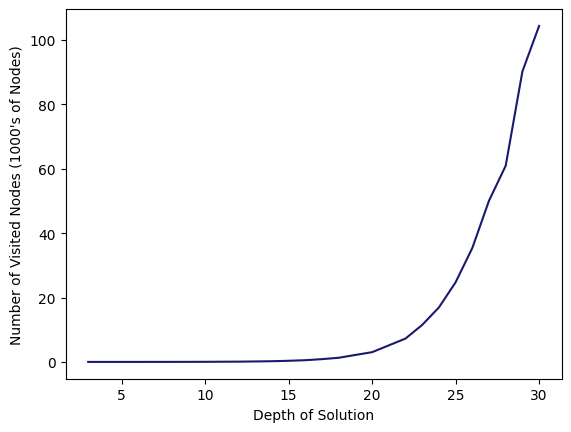

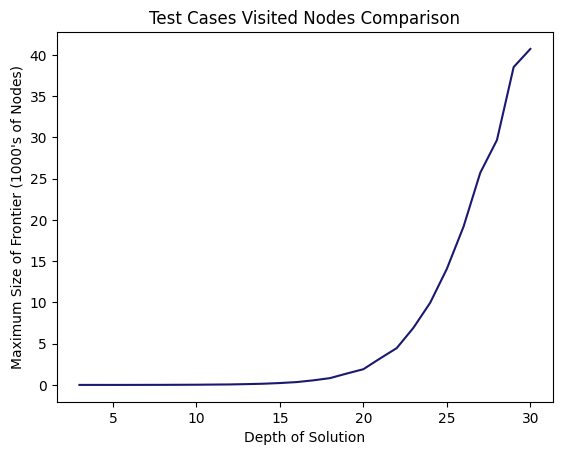

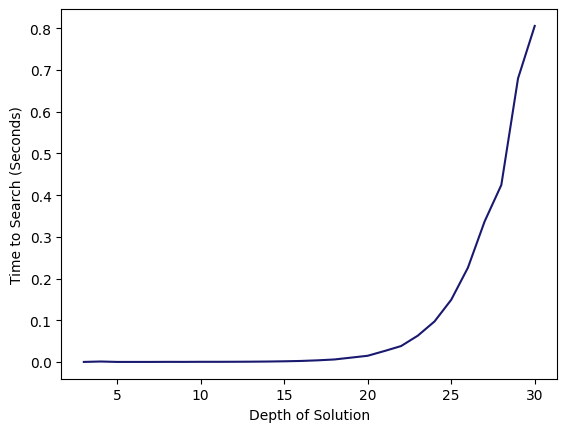

In [23]:
#results of monte carlo simulation with 100000 misplaced tile searches in c++
depthMT = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
visitedMT = [5, 6, 6.33333, 8.5, 14.7143, 16.1538, 28.0909, 40.48, 67, 91.5735, 150.207, 224.028, 357.836, 538.81, 869.767, 1295.7, 2171.28, 3033.34, 5145.1, 7261.01, 11498.1, 16919.4, 24736.4, 35373.9, 50071.1, 60936, 90221.9, 104345]
frontierMT = [5, 6, 5.33333, 7.16667, 11.5714, 13.2308, 21.3636, 29.92, 47.8205, 63.1176, 102.441, 149.892, 232.316, 348.967, 559.39, 828.177, 1381.47, 1909.11, 3209.31, 4468.1, 6932.63, 9956.31, 14072.2, 19191.6, 25710.8, 29681.6, 38520.3, 40720.5]
timeMT = [0, 1, 0, 0, 0, 0.153846, 0.0909091, 0.28, 0.25641, 0.367647, 0.576577, 0.920455, 1.51273, 2.31659, 3.80952, 5.875, 10.2993, 14.788, 26.1135, 38.0964, 63.0264, 97.0618, 149.058, 226.091, 336.976, 424.447, 679.886, 805.808]

plt.clf()
plt.cla()
plt.plot(depthMT, [visited/1000 for visited in visitedMT], color = "midnightblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Number of Visited Nodes (1000's of Nodes)")
plt.savefig("misplacedTileVisited.png")
plt.show()


plt.clf()
plt.cla()
plt.plot(depthMT, [frontier/1000 for frontier in frontierMT], color = "midnightblue")
plt.xlabel("Depth of Solution")
plt.title("Test Cases Visited Nodes Comparison")
plt.ylabel("Maximum Size of Frontier (1000's of Nodes)")
plt.savefig("misplacedTileFrontier.png")
plt.show()


plt.clf()
plt.cla()
plt.plot(depthMT, [time/1000 for time in timeMT], color = "midnightblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Time to Search (Seconds)")
plt.savefig("misplacedTileTime.png")
plt.show()

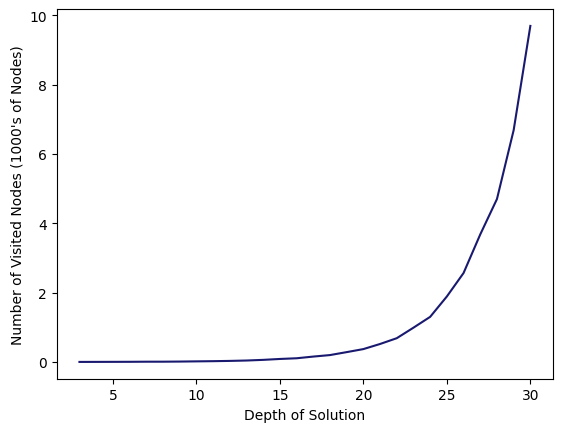

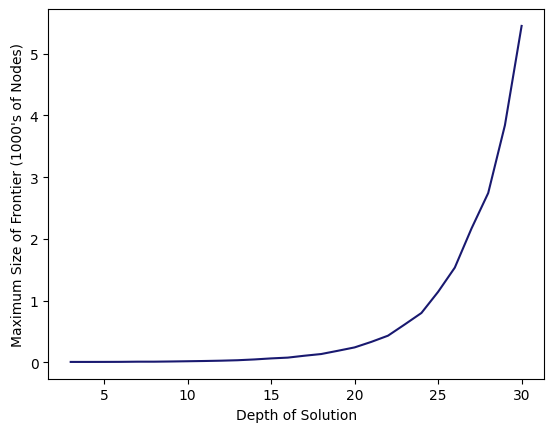

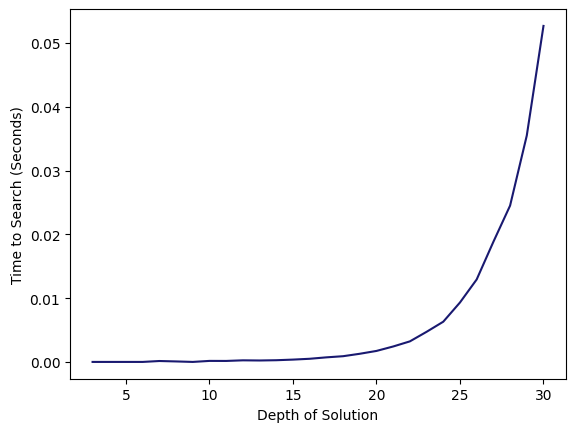

In [19]:
#results of monte carlo simulation with 18144 manhatan distance searches in c++
depthMD = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
visitedMD = [4, 5, 6, 7.33333, 10.2857, 10.7692, 14.2727, 20.12, 25.5897, 33.2794, 44.3964, 63.358, 89.4036, 109.38, 158.225, 201.482, 286.607, 374.157, 521.568, 688.359, 991.834, 1304.25, 1892.08, 2568.57, 3682.75, 4702.89, 6690.44, 9697.08]
frontierMD = [5, 5, 5.33333, 6.16667, 8.85714, 8.92308, 12.0909, 15.96, 20, 25.0441, 32.4324, 45.2216, 61.9964, 74.786, 105.526, 132.962, 185.717, 240.34, 329.812, 430.415, 612.077, 798.157, 1140.98, 1533.91, 2167.55, 2742.81, 3840.93, 5451.5]
timeMD = [0, 0, 0, 0, 0.142857, 0.0769231, 0, 0.16, 0.153846, 0.25, 0.225225, 0.267045, 0.363636, 0.49345, 0.716117, 0.896516, 1.27798, 1.72386, 2.41995, 3.22255, 4.7211, 6.30843, 9.32118, 12.9324, 18.8357, 24.5106, 35.5, 52.6923]

plt.clf()
plt.cla()
plt.plot(depthMD, [visited/1000 for visited in visitedMD], color = "midnightblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Number of Visited Nodes (1000's of Nodes)")
plt.savefig("manhattanDistanceVisited.png")
plt.show()


plt.clf()
plt.cla()
plt.plot(depthMD, [frontier/1000 for frontier in frontierMD], color = "midnightblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Maximum Size of Frontier (1000's of Nodes)")
plt.savefig("manhattanDistanceFrontier.png")
plt.show()


plt.clf()
plt.cla()
plt.plot(depthMD, [time/1000 for time in timeMD], color = "midnightblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Time to Search (Seconds)")
plt.savefig("manhattanDistanceTime.png")
plt.show()

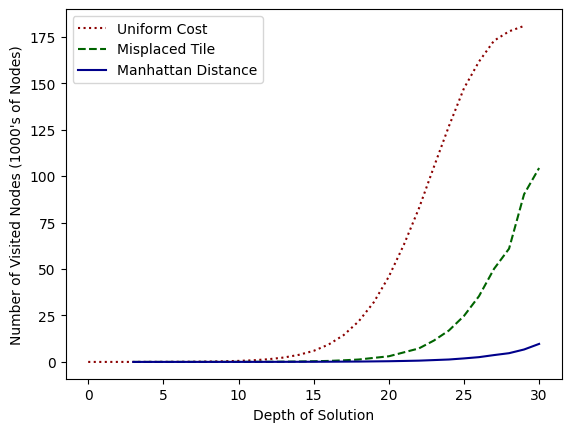

In [24]:
#plot all visited plots
plt.clf()
plt.cla()
plt.plot(depthUC, [visited/1000 for visited in visitedUC], label = "Uniform Cost", color = "darkred", linestyle = "dotted")
plt.plot(depthMT, [visited/1000 for visited in visitedMT], label = "Misplaced Tile", color = "darkgreen", linestyle = "dashed")
plt.plot(depthMD, [visited/1000 for visited in visitedMD], label = "Manhattan Distance", color = "darkblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Number of Visited Nodes (1000's of Nodes)")
plt.gca().legend(loc = "upper left")
plt.savefig("visitedComparison.png")
plt.show()

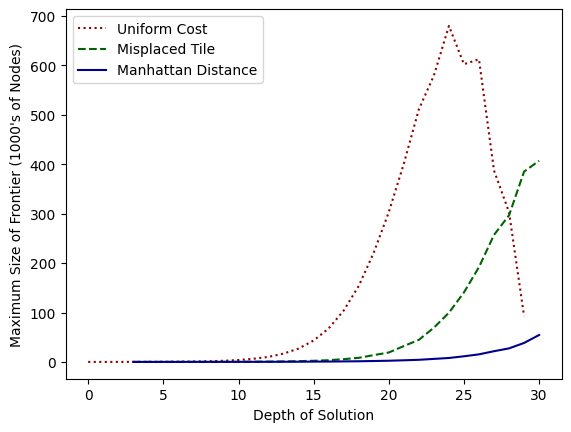

In [25]:
#plot all frontier plots
plt.clf()
plt.cla()
plt.plot(depthUC, [frontier/100 for frontier in frontierUC], label = "Uniform Cost", color = "darkred", linestyle = "dotted")
plt.plot(depthMT, [frontier/100 for frontier in frontierMT], label = "Misplaced Tile", color = "darkgreen", linestyle = "dashed")
plt.plot(depthMD, [frontier/100 for frontier in frontierMD], label = "Manhattan Distance", color = "darkblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Maximum Size of Frontier (1000's of Nodes)")
plt.gca().legend(loc = "upper left")
plt.savefig("frontierComparison.png")
plt.show()

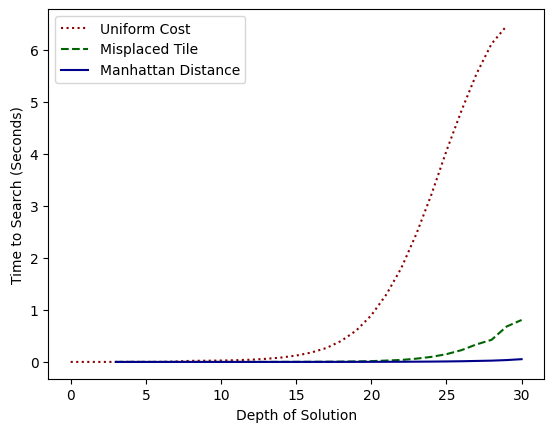

In [26]:
#plot all time plots
plt.clf()
plt.cla()
plt.plot(depthUC, [time/1000 for time in timeUC], label = "Uniform Cost", color = "darkred", linestyle = "dotted")
plt.plot(depthMT, [time/1000 for time in timeMT], label = "Misplaced Tile", color = "darkgreen", linestyle = "dashed")
plt.plot(depthMD, [time/1000 for time in timeMD], label = "Manhattan Distance", color = "darkblue")
plt.xlabel("Depth of Solution")
plt.ylabel("Time to Search (Seconds)")
plt.gca().legend(loc = "upper left")
plt.savefig("timeComparison.png")
plt.show()

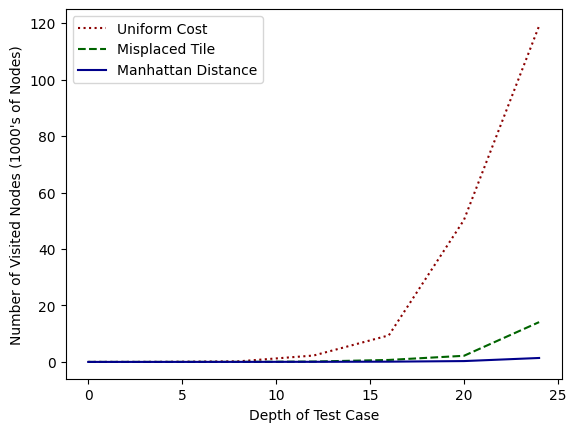

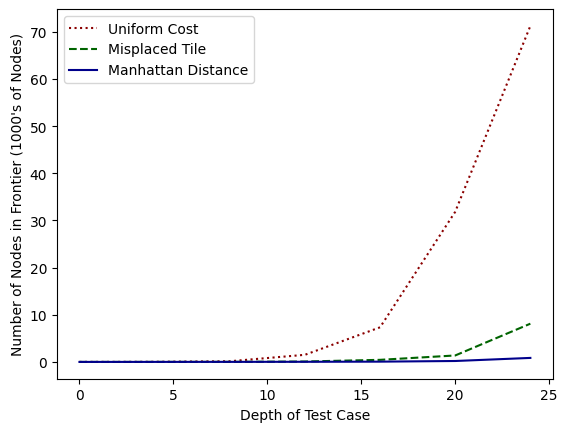

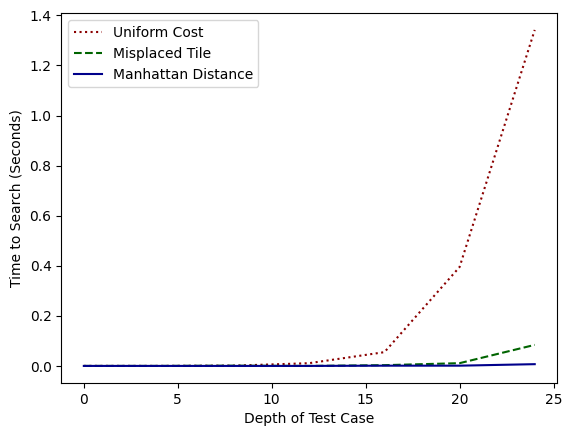

In [22]:
#test cases for manhattan distance
testDepth = [0, 2, 4, 8, 12, 16, 20, 24]

testVisitedMD = [1, 3, 5, 13, 37, 90, 300, 1397]
testFrontierMD = [1, 2, 5, 11, 27, 59, 197, 852]
testTimeMD = [0, 0, 0, 0, 0, 1, 1, 7]

testVisitedMT = [1, 3, 5, 20, 132, 701, 2172, 14095]
testFrontierMT = [1, 2, 5, 15, 88, 443, 1370, 8111]
testTimeMT = [0, 0, 0, 1, 0, 3, 11, 84]

testVisitedUC = [1, 6, 26, 205, 2268, 9401, 50280, 118998]
testFrontierUC = [1, 5, 21, 143, 1509, 7341, 31844, 71273]
testTimeUC = [0, 0, 0, 1, 11, 55, 395, 1342]

plt.clf()
plt.cla()
plt.plot(testDepth, [visited/1000 for visited in testVisitedUC], label = "Uniform Cost", color = "darkred", linestyle = "dotted")
plt.plot(testDepth, [visited/1000 for visited in testVisitedMT], label = "Misplaced Tile", color = "darkgreen", linestyle = "dashed")
plt.plot(testDepth, [visited/1000 for visited in testVisitedMD], label = "Manhattan Distance", color = "darkblue")
plt.xlabel("Depth of Test Case")
plt.ylabel("Number of Visited Nodes (1000's of Nodes)")
plt.gca().legend(loc = "upper left")
plt.savefig("testVisitedComparison.png")
plt.show()


plt.clf()
plt.cla()
plt.plot(testDepth, [frontier/1000 for frontier in testFrontierUC], label = "Uniform Cost", color = "darkred", linestyle = "dotted")
plt.plot(testDepth, [frontier/1000 for frontier in testFrontierMT], label = "Misplaced Tile", color = "darkgreen", linestyle = "dashed")
plt.plot(testDepth, [frontier/1000 for frontier in testFrontierMD], label = "Manhattan Distance", color = "darkblue")
plt.xlabel("Depth of Test Case")
plt.ylabel("Number of Nodes in Frontier (1000's of Nodes)")
plt.gca().legend(loc = "upper left")
plt.savefig("testFrontierComparison.png")
plt.show()

plt.clf()
plt.cla()
plt.plot(testDepth, [time/1000 for time in testTimeUC], label = "Uniform Cost", color = "darkred", linestyle = "dotted")
plt.plot(testDepth, [time/1000 for time in testTimeMT], label = "Misplaced Tile", color = "darkgreen", linestyle = "dashed")
plt.plot(testDepth, [time/1000 for time in testTimeMD], label = "Manhattan Distance", color = "darkblue")
plt.xlabel("Depth of Test Case")
plt.ylabel("Time to Search (Seconds)")
plt.gca().legend(loc = "upper left")
plt.savefig("testTimeComparison.png")
plt.show()